In [1]:
import os
import cv2
import skimage.io as io
import keras
from keras.preprocessing import image
from keras.applications import vgg16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.optimizers import Adam, SGD
from skimage.io import imread
from shapely.geometry import mapping
from shapely.geometry import Point
from shapely.geometry import Polygon as Pgon
from shapely.geometry import MultiPoint
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline
import numpy as np
from skimage.segmentation import mark_boundaries
from skimage.segmentation import find_boundaries
%load_ext autoreload
%autoreload 2
import sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image
import time
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
Using TensorFlow backend.


### Helper Functions

In [2]:
def getCatId(imgId):
    for k in catId_to_imgId.keys():
        if imgId in catId_to_imgId[k]:
            return k
    print("imgId not found")
    raise Exception

In [3]:
def show_gt_mask(bbox_img, polygons, colors):
    """Show ground truth object segmentation mask
    
    Args:
        bbox_img (array): cropped version of original image to bounding box of object segmentation mask
        polygons (array): array of matplotlib Polygon objects
        colors (array): array of floats representing colors
    
    Returns:
        None
        
    Output:
        Shaded and outlined object segmentation mask in bounding box image provided
    """
    assert len(polygons) == len(colors)
    plt.imshow(bbox_img)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    p = PatchCollection(polygons, facecolor=colors, linewidths=0, alpha=0.4)
    ax.add_collection(p)
    p = PatchCollection(polygons, facecolor='none', edgecolors=colors, linewidths=2)
    ax.add_collection(p)

In [4]:
def pairwise_group(alt_seg):
    """Converts a flattened array to an array of tuples
    
    Args:
        alt_seg (array-like): array of sequential object segmentation points
    
    Returns:
        pgon_pts (array of tuples): array of sequential points of a polygon
    """
    pgon_pts = []
    assert len(alt_seg) % 2 == 0
    for i in range(len(alt_seg) // 2):
        pgon_pts.append((alt_seg[2 * i], alt_seg[2 * i + 1]))
    return pgon_pts

In [5]:
def getBboxImgXY(img, ann):
    x0, y0, width, height = ann['bbox']
    x1, y1 = int(x0 + width + 0.5), int(y0 + height + 0.5)
    x0, y0 = int(x0), int(y0)
    bboxImg = np.copy(img[y0:y1, x0:x1])
    return bboxImg, x0, y0

In [6]:
def getPgonsBboxImgsColorsAltSegs(img, anns, polygons):
    assert len(anns) == len(polygons)
    pgons, bboxImgs, colors, alt_segs = [], [], [], []
    for i in range(len(anns)):
        ann = anns[i]
        
        bboxImg, x0, y0 = getBboxImgXY(img, ann)
        bboxImgs.append(bboxImg)

        c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
        if 'segmentation' in ann:
            if type(ann['segmentation']) == list:
                
                alt_seg = np.copy(ann['segmentation'])
                for seg in alt_seg:
                    for i in range(len(seg)):
                        if i % 2 == 0:
                            seg[i] = int(seg[i] - x0)
                        else:
                            seg[i] = int(seg[i] - y0)
                alt_segs.append(alt_seg)

                _pgons = []
                _colors = []
                for seg in alt_seg:
                    poly = np.array(seg).reshape((int(len(seg)/2), 2))
                    _pgons.append(Polygon(poly))
                    _colors.append(c)
                pgons.append(_pgons)
                colors.append(_colors)
    return pgons, bboxImgs, colors, alt_segs

In [7]:
def getPolygonsLabelsMasksColorsBboxImgs(img, anns):
    count = 1
    polygons, object_labels = [], []
    _to_remove = []
    for ann in anns:
        c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
        if 'segmentation' in ann:
            if type(ann['segmentation']) == list:
                # Get label info
                cat_info = coco.loadCats(ann['category_id'])[0]
                object_labels.append((cat_info['id'], cat_info['name']))
                
                # Create matplotlib Polygon
                polys = []
                for seg in ann['segmentation']:
                    poly = np.array(seg).reshape((int(len(seg)/2), 2))
                    polys.append(Polygon(poly))
                polygons.append(polys)
            else:
                _to_remove.append(ann)
        else:
            _to_remove.append(ann)
    
    for a in _to_remove:
        anns.remove(a)
    
    pgons, bboxImgs, colors, alt_segs = getPgonsBboxImgsColorsAltSegs(img, anns, polygons)
    return pgons, object_labels, alt_segs, colors, bboxImgs

In [8]:
def preprocess(img):
    I = np.copy(io.imread(img['coco_url']))
    
    # Get obj seg/bbox annotations of img
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=used_ids, iscrowd=None).copy()
    anns = coco.loadAnns(annIds).copy()
    
    polygons, object_labels, alt_segs, colors, bboxImgs = getPolygonsLabelsMasksColorsBboxImgs(I, anns)
    
    x = len(polygons)
    assert len(object_labels) == x, (x, len(object_labels))
    assert len(alt_segs) == x, (x, len(alt_segs))
    assert len(colors) == x, (x, len(colors))
    assert len(bboxImgs) == x, (x, len(bboxImgs))
    
    # In order to call show_gt_mask(*config)
    configs = []
    for i in range(len(polygons)):
        configs.append((bboxImgs[i], polygons[i], colors[i]))
    
    # In order to check which points are in the shapely Polygon later
    shapelyPolygons = []
    for seg in alt_segs:
        shapelyPolygons.append(Pgon(pairwise_group(seg[0])))
    
    assert len(configs) == len(shapelyPolygons)
    
    return bboxImgs, object_labels, configs, shapelyPolygons

### Load Dataset

In [9]:
dataDir=''
dataType='val2017'
annFile='annotations/instances_{}.json'.format(dataType)

In [10]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.69s)
creating index...
index created!


In [11]:
num_cats = 10

In [12]:
# Get categories with largest number of images to use
numCatImgs = []
for i in range(90):
    numCatImgs.append((i, len(coco.getImgIds(catIds=i))))
numCatImgs.sort(key=lambda x: x[1])
usedCatImgs = numCatImgs[-num_cats:] # list of (catId, numImgs) tuples
minNumImgs = usedCatImgs[0][1] # number of images available for smallest used cat(egory)
used_ids = [tup[0] for tup in usedCatImgs] # list of catIds used

used_cats = coco.loadCats(coco.getCatIds(catIds=used_ids))
cat_names = [cat['name'] for cat in used_cats]
print('{} COCO categories used: \n{}\n'.format(len(used_cats), ' '.join(cat_names)))

10 COCO categories used: 
person car truck bench handbag bottle cup bowl chair dining table



In [13]:
print(used_ids)

[15, 8, 31, 51, 44, 47, 67, 3, 62, 1]


### Load All Images

In [14]:
imgIds = [img_info for used_id in used_ids for img_info in coco.getImgIds(catIds=used_id)]

In [16]:
%%time
# preprocess --> bboxImgs, object_labels, configs, shapelyPolygons
data = [preprocess(img_info) for img_info in coco.loadImgs(imgIds)]
data = np.array(data)
np.random.shuffle(data)

CPU times: user 1min 27s, sys: 6.16 s, total: 1min 33s
Wall time: 10min 27s


### Using Keras VGG16 Model

In [17]:
def calcIoU(gt_pgon, pred_seg, seg_ids):
    """Calculate IoU of gt_mask (shapely Polygon) + LIME seg
    
    Args:
        gt_pgon (shapely Polygon): mask of ground truth object segmentation
        pred_seg (np.array): segmentation algorithm output
        seg_ids (array-like): ids of impactful segments
    
    Returns:
        iou (float): measure of accuracy of LIME segmentation to ground truth
    """
    pred_coords = []
    for num in seg_ids:
        shape = np.where(pred_seg == num)
        # Not sure why transformation is required ...
        pred_coords.extend(list(zip(shape[1], shape[0] * -1 + pred_seg.shape[1])))
    
    gt_coords = mapping(gt_pgon)['coordinates']
    
    coords_in_intersection = 0
    for coord in pred_coords:
        if gt_pgon.contains(Point(coord)):
            coords_in_intersection += 1
    
    num_coords_in_union = len(pred_coords) + len(gt_coords) - coords_in_intersection
    
    return coords_in_intersection / num_coords_in_union   

In [18]:
input_tensor = Input(shape=(96, 96, 3))
inet_model = vgg16.VGG16(input_tensor=input_tensor, weights=None, include_top=False)

In [19]:
num_samples = 100
batch_size = 10
num_classes = 10
num_batches = num_samples // batch_size
iteration = 0

base_model = inet_model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['acc'])

In [33]:
class SubPlotter:
        
    def __init__(self, num_rows=1, use_bandits=True):
        self.graph_count = 0
        self.use_bandits = use_bandits
        self.start = time.time()
        self.fig, self.axeslist = plt.subplots(ncols=3, nrows=num_rows, figsize=(8 * 3, 10 * num_rows))
        
    def analyzeIoU(self, x_train_batch, y_train_batch, shapely_polygons_batch, 
                   num_accurate=10, num_inaccurate=10, good=0.7, bad=0.3):
        x = len(x_train_batch)
        assert len(y_train_batch) == x
        assert len(shapely_polygons_batch) == x
        i, acc, not_acc = 0, 0, 0
        info = [] # contains tuples (i, expl
        while acc < num_accurate and not_acc < num_inaccurate or i < x: 
            explainer = lime_image.LimeImageExplainer()
            expl = explainer.explain_instance(img, model.predict, top_labels=1, hide_color=0,
                                              num_samples=100, timed=True, batch_size=batch_size,
                                              use_bandits=self.use_bandits)
            score = calcIoU(shapely_polygons_batch[i], explainer.segments, explainer.features_to_use)
            if scores <= bad:
                not_acc += 1
                info.append((i, expl))
            elif scores >= good:
                acc += 1
                info.append((i, expl))
            i += 1
        return info
    
    def plog_seg_extremes(self, info, configs_batch):
        for i, expl in info:
            img, polygons, colors = configs[i]
            
            # Display original image
            _sp = self.axeslist.ravel()[self.graph_count]
            _sp.imshow(img / 2 + 0.5, cmap=plt.gray())
            _sp.set_axis_off()
            self.graph_count += 1

            # Display superpixel contrib
            temp, mask = expl.get_image_and_mask(expl.top_labels[0], positive_only=False, 
                                                 num_features=5, hide_rest=False)
            _sp = self.axeslist.ravel()[self.graph_count]
            _sp.imshow(mark_boundaries(temp, mask) / 2 + 0.5, cmap=plt.gray())
            _sp.set_axis_off()
            self.graph_count += 1
            
            # Display ground truth object segmentation
            _sp = self.axeslist.ravel()[self.graph_count]
            _sp.imshow(bbox_img)
            ax = _sp.gca()
            ax.set_autoscale_on(False)
            p = PatchCollection(polygons, facecolor=colors, linewidths=0, alpha=0.4)
            ax.add_collection(p)
            p = PatchCollection(polygons, facecolor='none', edgecolors=colors, linewidths=2)
            ax.add_collection(p)
            self.graph_count += 1

    def end(self):
        plt.tight_layout()
        plt.show()
        end = time.time()
        diff = end - self.start
        print("Ran for {} seconds!! ({} minutes)".format(round(diff, 3), round(diff / 60, 3)))

In [20]:
x_train = data[:, 0] # Bbox images

temp = []
for bbox_imgs in x_train:
    for img in bbox_imgs:
        if len(img.shape) != 3:
            img = np.stack((img,) * 3, -1)
        alt_img = cv2.resize(img, dsize=(96, 96), interpolation=cv2.INTER_CUBIC)
        temp.append(alt_img)

x_train = np.array(temp)

In [21]:
y_train = data[:, 1]
y_train = np.array([label[0] for labels in y_train for label in labels])

temp = np.zeros((y_train.shape[0], num_cats))
for ft in used_ids:
    vec = np.zeros(num_cats)
    vec[used_ids.index(ft)] = 1
    temp[np.where(y_train == ft)] = vec

y_train = temp

In [28]:
configs = np.array([config for configs in data[:, 2] for config in configs])

In [30]:
shapely_polygons = np.array([polygon for polygons in data[:, 3] for polygon in polygons])

In [22]:
# Make sure model trains
model.fit(x_train, y_train,
          epochs=10,
          batch_size=128,
          shuffle=False,
          validation_split=0.1)

print("Evaluating ...")
model.evaluate(x_train, y_train, batch_size=128, verbose=0)

Train on 40344 samples, validate on 4483 samples
Epoch 1/10
40344/40344 [==============================] - 166s 4ms/step - loss: 1.8093 - acc: 0.4727 - val_loss: 2.0179 - val_acc: 0.4691
Epoch 2/10
40344/40344 [==============================] - 155s 4ms/step - loss: 1.7377 - acc: 0.4757 - val_loss: 1.9420 - val_acc: 0.4691
Epoch 3/10
40344/40344 [==============================] - 155s 4ms/step - loss: 1.7027 - acc: 0.4761 - val_loss: 1.9107 - val_acc: 0.4691
Epoch 4/10
40344/40344 [==============================] - 155s 4ms/step - loss: 1.6776 - acc: 0.4776 - val_loss: 1.9092 - val_acc: 0.4691
Epoch 5/10
40344/40344 [==============================] - 155s 4ms/step - loss: 1.6604 - acc: 0.4792 - val_loss: 1.9132 - val_acc: 0.4691
Epoch 6/10
40344/40344 [==============================] - 155s 4ms/step - loss: 1.6474 - acc: 0.4807 - val_loss: 1.9004 - val_acc: 0.4689
Epoch 7/10
40344/40344 [==============================] - 155s 4ms/step - loss: 1.6369 - acc: 0.4822 - val_loss: 1.9132 - v

[1.8887753149484847, 0.4745800521933695]

Train on 1000 samples, validate on 100 samples
Epoch 1/1
1000/1000 [==============================] - 17s 17ms/step - loss: 1.6663 - acc: 0.5040 - val_loss: 1.5769 - val_acc: 0.5300


ValueError: Error when checking : expected input_1 to have shape (96, 96, 3) but got array with shape (98, 74, 3)

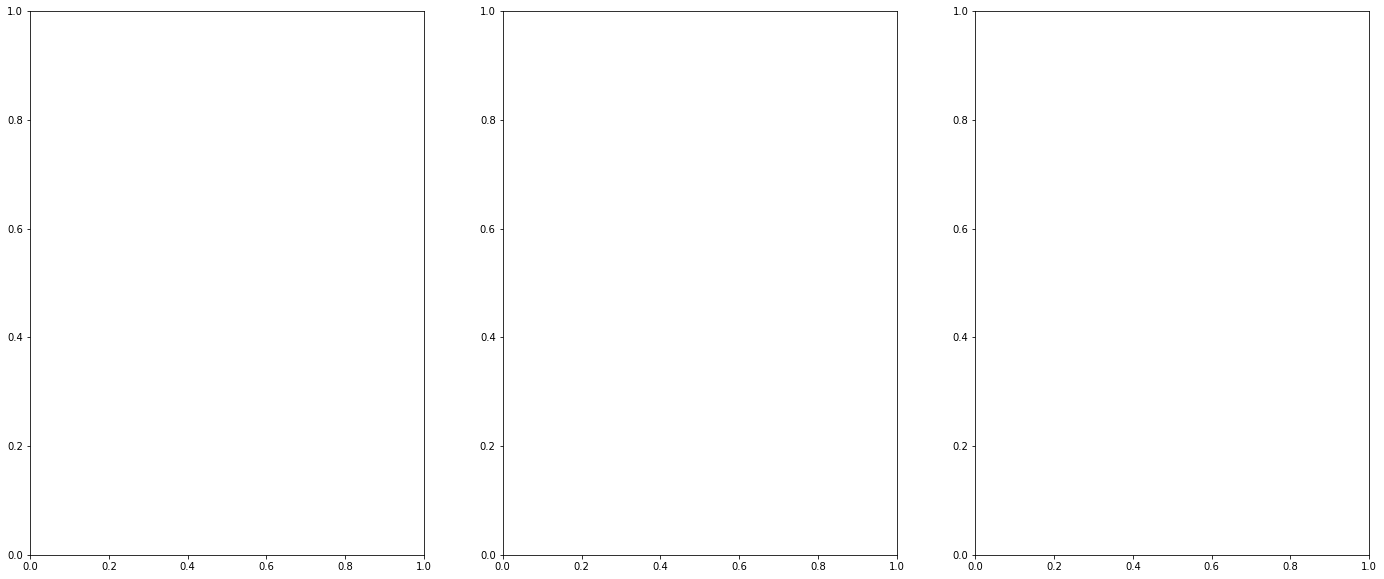

In [34]:
%%time
# Using Epsilon-Greedy
start_iter = 0
num_training_samples = 1000
num_iterations = 1
samples_per_iter = num_training_samples // num_iterations
explainer_batch_size = 128
batch_size = 128
sp = SubPlotter(num_iterations, use_bandits=True)

for iteration in range(start_iter, start_iter + num_iterations):
    start = iteration * samples_per_iter
    end = (iteration + 1) * samples_per_iter
    
    x_train_batch = x_train[start:end]
    y_train_batch = y_train[start:end]
    configs_batch = configs[start:end]
    shapely_polygons_batch = configs[start:end]
    
    model.fit(x_train_batch, y_train_batch,
              epochs=1,
              batch_size=batch_size,
              shuffle=False,
              validation_data=(x_train[-100:], y_train[-100:]))
    
    info = sp.analyzeIoU(x_train_batch, y_train_batch, shapely_polygons_batch)
    sp.plot_seg_extremes(info, configs_batch)
    
    print("loss, accuracy = {}\n".format(model.evaluate(x_train, y_train, batch_size=128, verbose=0)))

sp.end()

### Load Single Image

In [62]:
imgIds = [img_info for used_id in used_ids for img_info in coco.getImgIds(catIds=used_id)]
# img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])
img = coco.loadImgs(70229)[0]

In [63]:
print(img)

{'license': 1, 'file_name': '000000070229.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000070229.jpg', 'height': 640, 'width': 481, 'date_captured': '2013-11-24 02:18:11', 'flickr_url': 'http://farm8.staticflickr.com/7174/6397141265_aa0f0d8a4e_z.jpg', 'id': 70229}


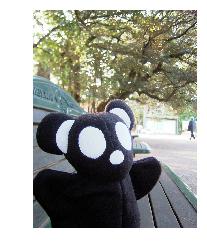

In [64]:
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

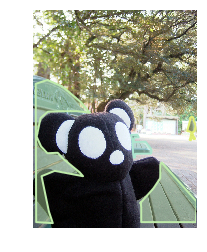

In [65]:
# load and display instance annotations
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=used_ids, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [69]:
bboxImgs, object_labels, configs, shapelyPolygons = preprocess(img)

In [70]:
print(len(configs))

3


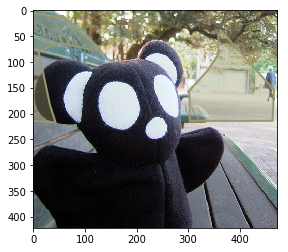

In [71]:
show_gt_mask(*configs[1])

p = Pgon(pairwise_group(alt_segs[0][0]))  
p.contains(Point(20, 60))